In [1]:
import sys
sys.path.append('./detr/')

In [2]:
from util.plot_utils import plot_logs
from pathlib import Path

log_directory = [Path('./data/output/')]

## loss logs

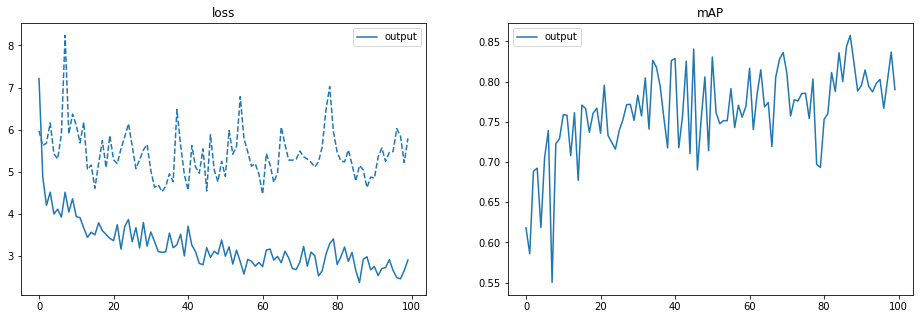

In [19]:
fields_of_interest = (
    'loss',
    'mAP',
)
plot_logs(log_directory, fields_of_interest)

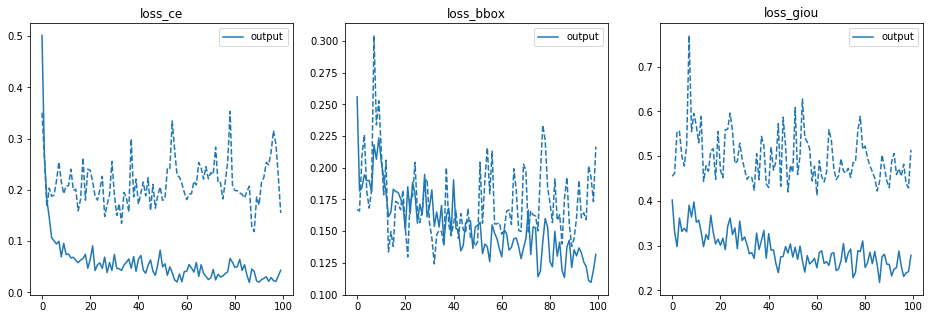

In [20]:
fields_of_interest = (
    'loss_ce',
    'loss_bbox',
    'loss_giou',
)

plot_logs(log_directory, fields_of_interest)

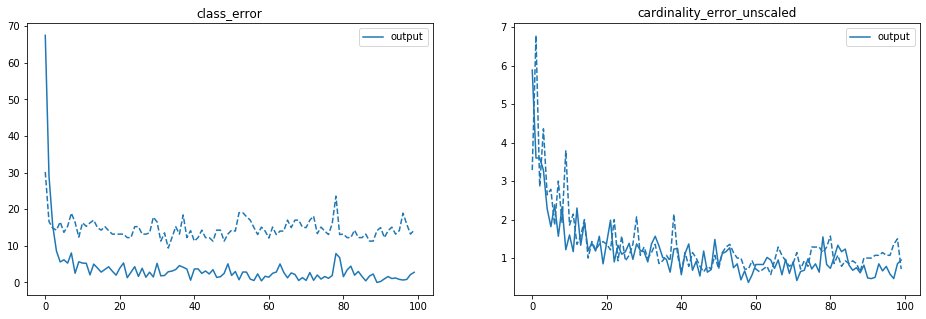

In [21]:
fields_of_interest = (
    'class_error',
    'cardinality_error_unscaled',
)

plot_logs(log_directory, fields_of_interest)   

## check model results

In [22]:
import torch
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as T

In [23]:
def plot_finetuned_results(pil_img, prob=None, boxes=None):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    if prob is not None and boxes is not None:
        for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
            ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                    fill=False, color=c, linewidth=3))
            cl = p.argmax()
            text = f'{finetuned_classes[cl]}: {p[cl]:0.2f}'
            ax.text(xmin, ymin, text, fontsize=15,
                  bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()


def run_worflow(my_image, my_model, probs=[0.9, 0.7]):
    # mean-std normalize the input image (batch-size: 1)
    img = transform(my_image).unsqueeze(0)

    # propagate through the model
    outputs = my_model(img)

    for threshold in probs:
        probas_to_keep, bboxes_scaled = filter_bboxes_from_outputs(outputs,
                                                                  threshold=threshold)
        plot_finetuned_results(my_image,
                               probas_to_keep, 
                               bboxes_scaled)


def filter_bboxes_from_outputs(outputs, threshold=0.7):
    # keep only predictions with confidence above threshold
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > threshold

    probas_to_keep = probas[keep]

    # convert boxes from [0; 1] to image scales
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)

    return probas_to_keep, bboxes_scaled


def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)


def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b


In [24]:
COLORS = [
    [0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
    [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]
]
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
num_classes = 1
finetuned_classes = ['balloon']

In [25]:
model = torch.hub.load(
    'facebookresearch/detr',
    'detr_resnet50',
    pretrained=False,
    num_classes=num_classes
)

checkpoint = torch.load(
    './data/output/checkpoint.pth',
    map_location='cpu'
)

model.load_state_dict(
    checkpoint['model'], strict=False
)

model.eval()

Using cache found in /home/muhsin/.cache/torch/hub/facebookresearch_detr_master


DETR(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): _LinearWithBias(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): _LinearWithBias(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
       

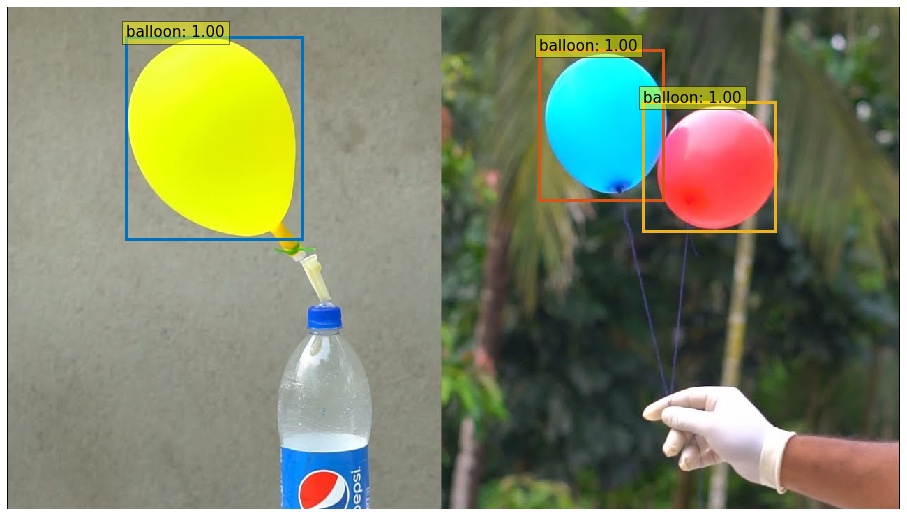

In [28]:
img_name = './data/balloon_1.jpg'
im = Image.open(img_name)
run_worflow(im, model, probs=[0.9])

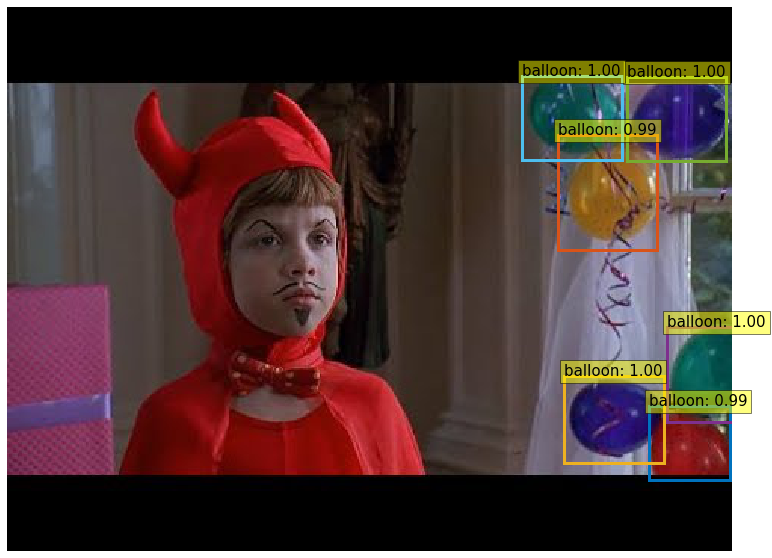

In [29]:
img_name = './data/balloon_2.jpeg'
im = Image.open(img_name)
run_worflow(im, model, probs=[0.9])